In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Placeholders for input (batch, 784) and output (batch, 10)

In [2]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

**x_image**: tensor of shape [-1, 28, 28, 1]
* -1: Batch size (computed from data)
* 28: Height of image
* 28: Width of image
* 1: Numbers of color channels (MNIST images are black-white, so only one color channel)

In [4]:
x_image = tf.reshape(x, [-1,28,28,1])

The first Conv layer contains 32 filters each with a unique set of learnable values: 5 \* 5 \* 1 weights, plus one bias.

The total number of parameters is 32 \* (5 \* 5 \* 1 + 1) = 832

**W_conv1**: tensor of shape [5, 5, 1, 32]
* 5: Height of receptive field
* 5: Width of receptive field
* 1: Number of input channels
* 32: Number of depth slices in the output volume (or number of filters applied on the input volume)

**b_conv1**: tensor of shape [32]
* 32: The biases of the 32 filters 

In [5]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

The hyperparameters of the first Conv layer should be:
* Input size (**W**): 28
* Patch size of filter (**F**): 5
* Stride with which filter is applied on input image (**S**): 1
* Size of zero-padding (**P**): 2

(W - F + 2P) / S + 1 = (28 - 5 + 2 \* 2) / 1 + 1 = 28, which is the same as the input image size

So the first Conv layer will transform an input image of shape (batch, 28, 28, 1) into (batch, 28, 28, 32)

In [6]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

The first Pool layer has the following hyperparameters:
* Patch size (**F**): 2
* Stride (**S**): 2

So the first Pool layer will pick the max of the four values for each of the non-overlapping 2-by-2 patch. The (batch, 28, 28, 32) tensor output from the first Conv layer will be transformed into a (batch, 14, 14, 32) tensor. 

In [7]:
h_pool1 = max_pool_2x2(h_conv1)

Similarly, the second Conv layer contains 64 filters so it will transform input tensor of shape (batch, 14, 14, 32) into (batch, 14, 14, 64) tensor; and the second Pool layer will transform input tensor of shape (batch, 14, 14, 64) into (batch, 7, 7, 64)

In [8]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

The output volume from the second Pool layer of shape (batch, 7, 7, 64) will be reshaped into (batch, 7\*7\*64)

It will be transformed in to tensor of shape (batch, 1024) by 1024 neurons each containing 7\*7\*64 weights, that is, (batch, 7\*7\*64) dot (7\*7\*64, 1024) = (batch, 1024)

In [9]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

During training a subset of the 1024 neuros will be dropout with a given probability, those that were kept will be scaled to make sure that their expected sum will be approximately the same.

In [10]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we need a readout layer that transform tensor of shape (batch, 1024) into (batch, 10) ((batch, 1024) dot (1024, 10)), which are interpreted as the confidence scores for the 10 digits.

In [11]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

The total number of learnable parameters (3,274,634) is calculated as follows 

* First Conv layer: 32 \* (5 \* 5 \* 1 + 1) = 832
* Second Conv layer: 64 \* (5 \* 5 \* 32 + 1) = 51,264
* Fully connected layer: 7\*7\*64 \* 1024 + 1024 = 3,212,288
* Readout layer (fully connected): 1024 \* 10 + 10 = 10,250

The architechture of this simple ConvNet:

[Conv] => [RELU] => [Pool] => [Conv] => [RELU] => [Pool] => [FC] => [FC]

Now let's kick off the computation graph in a session

In [12]:
# labels: true class labels
# logits: predicted confidence scores for class labels
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.global_variables_initializer())

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i % 2000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print "step %d, training accuracy %g" % (i, train_accuracy)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.1
step 2000, training accuracy 0.96
step 4000, training accuracy 1
step 6000, training accuracy 1
step 8000, training accuracy 1
step 10000, training accuracy 1
step 12000, training accuracy 1
step 14000, training accuracy 1
step 16000, training accuracy 0.98
step 18000, training accuracy 1


In [13]:
step_size = 1000
y_pred = []
for i in range(0, 10000, step_size):
    batch = y_conv.eval(feed_dict={x: mnist.test.images[i : i + step_size], keep_prob: 1.0})
    batch = np.apply_along_axis(np.argmax, 1, batch)
    y_pred.extend(batch)

y_true = np.apply_along_axis(np.argmax, 1, mnist.test.labels)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

miss_class = np.where(y_pred != y_true)[0]

In [14]:
sess.close()

In [15]:
print "accuracy =", 1 - len(miss_class) / 10000.

accuracy = 0.9919


Finally let's print out some of the miss classified images:

predicted = 5, true = 9


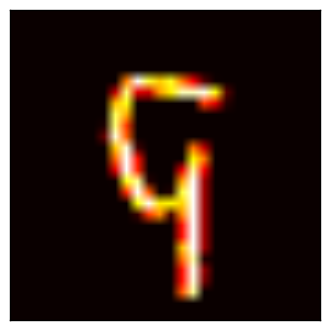

predicted = 9, true = 4


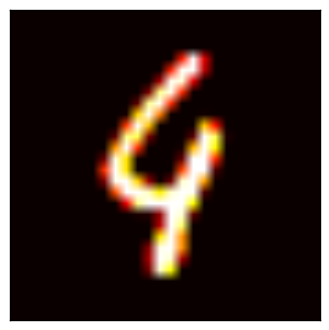

predicted = 2, true = 4


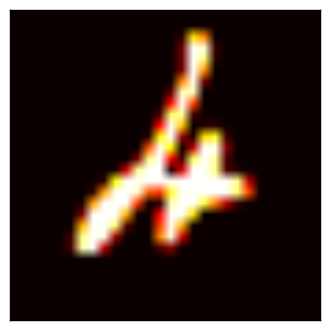

predicted = 0, true = 6


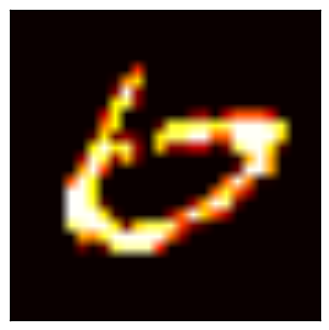

predicted = 5, true = 3


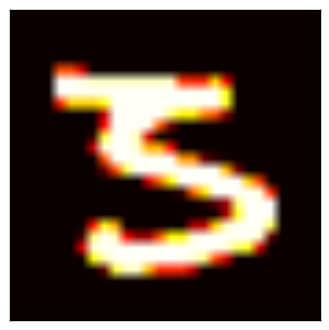

In [16]:
import matplotlib.pyplot as plt

for i in miss_class[:5]:
    print "predicted = %d, true = %d" % (y_pred[i], y_true[i])
    plt.imshow(mnist.test.images[i].reshape((28, 28)), cmap="hot")
    plt.xticks([])
    plt.yticks([])
    plt.show()

Some of the images were so ambiguous (like 4 and 9) that it's hard to tell the correct label even manually. So the ConvNet did a pretty good job.